In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df = pd.read_csv(r'../data/National_only.csv')

In [3]:
def parse_ranges_to_dict(ranges):
    range_dict = {}
    for r in ranges:
        if '<' in r:
            start = 0
            end = float(r.split('<')[-1])
        elif '>=' in r:
            start = float(r.split('>=')[-1])
            end = start*2
        elif '-' in r:
            start, end = map(float, r.split('-'))
        else:
            raise ValueError(f"Invalid range format: {r}")
        range_dict[r] = (start, end)
    return range_dict



In [4]:

#columns that represent trip amounts per distance bin
cols = [x for x in df.columns if 'Number of Trips ' in x]

#Minimum and Maximum distance to belong to a specific bin
ranges = parse_ranges_to_dict([x.split(' ')[-1] for x in cols]).values()

distance_bins={}
for cname,(start,end) in zip(cols,ranges):
    distance_bins[cname]=(start+end)/2

bin_widths   = {col: (high - low) for col, (low, high) in zip(cols, ranges)}

In [5]:
new_rows = []

# Iterate through each row in df
for _, row in df.iterrows():
    # For each bin, create a new row with the corresponding distance and number of trips
    for col in cols:
        new_row = {
            'Distance': distance_bins[col],
            'Trips': row[col],
            'Bin_Width':bin_widths[col]
        }
        new_rows.append(new_row)

# Create a new dataframe with the new rows
df_new = pd.DataFrame(new_rows)

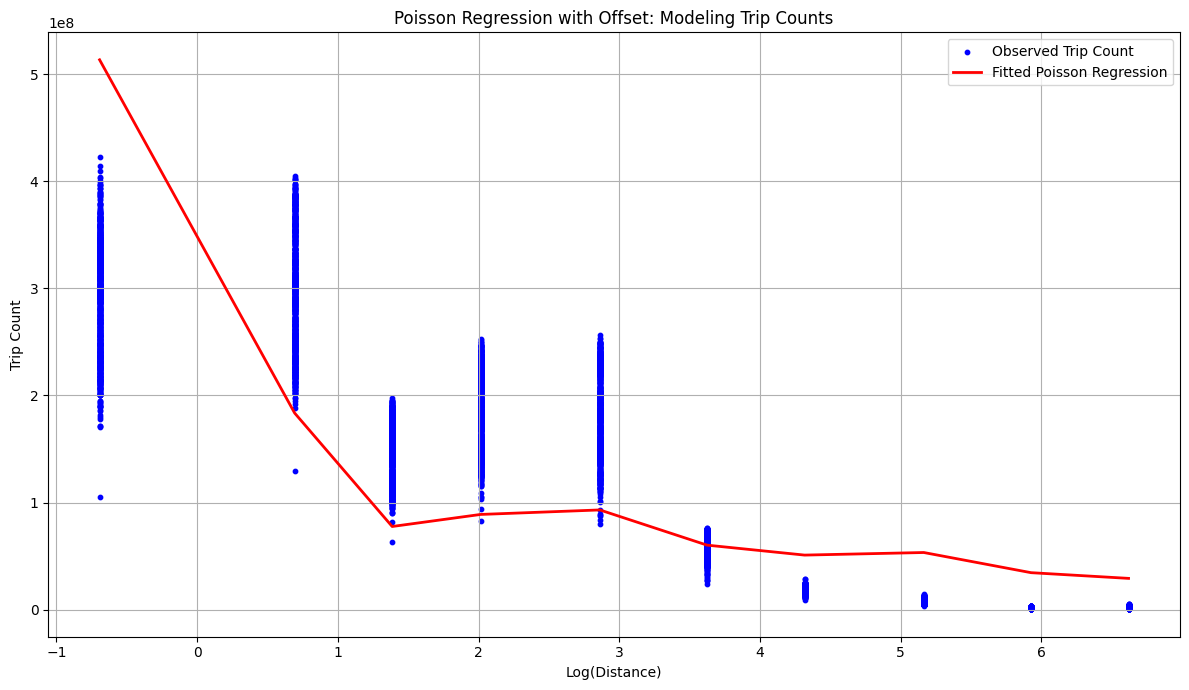

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_model = df_new.copy(deep=True)

# Create log-distance and log-bin-width columns
df_model['Log_Distance'] = np.log(df_model['Distance'])

df_model['Log_Bin_Width'] = np.log(df_model['Bin_Width'])

# Fit the Poisson regression with offset
poisson_model = sm.GLM(df_model['Trips'], sm.add_constant(df_model[['Log_Distance']]),
                       family=sm.families.Poisson(), offset=df_model['Log_Bin_Width'])
poisson_result = poisson_model.fit()

# Predict expected counts 
df_model['Predicted_Trips'] = poisson_result.predict(sm.add_constant(df_model[['Log_Distance']]), offset=df_model['Log_Bin_Width'])

# Sort the dataframe by Log_Distance for proper line plotting
df_model_sorted = df_model.sort_values(by='Log_Distance')

# Plotting
plt.figure(figsize=(12, 7))
plt.scatter(df_model_sorted['Log_Distance'], df_model_sorted['Trips'], color='blue', s=10, label='Observed Trip Count')
plt.plot(df_model_sorted['Log_Distance'], df_model_sorted['Predicted_Trips'], color='red', linewidth=2, label='Fitted Poisson Regression')
plt.xlabel("Log(Distance)")
plt.ylabel("Trip Count")
plt.title("Poisson Regression with Offset: Modeling Trip Counts")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
df_model.columns

Index(['Distance', 'Trips', 'Bin_Width', 'Log_Distance', 'Log_Bin_Width',
       'Predicted_Trips'],
      dtype='object')

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt



# Evaluation Metrics
mae = mean_absolute_error(df_model['Trips'], df_model['Predicted_Trips'])
rmse = np.sqrt(mean_squared_error(df_model['Trips'], df_model['Predicted_Trips']))
r2 = r2_score(df_model['Trips'], df_model['Predicted_Trips'])

print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")



Mean Absolute Error (MAE): 72,438,073.01
Root Mean Squared Error (RMSE): 97,654,539.99
R² Score: 0.2831
